## Multi-mode data

Finally we repeat the modelling part of this notebook using in this case multiple modes (fundamental, 1st, and 2nd).

In [2]:
# %matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
from PIL import Image

from functools import partial
from scipy.optimize import minimize, Bounds
from disba import PhaseDispersion

from surfacewaves import *
from dispersionspectra import *
from inversion import *

import ccfj
import scipy
from Dispersion.dispersion import get_dispersion


In [3]:
def get_cpr(thick, vs, period):
    
    true_model = np.vstack([thick, vs*4, vs, np.ones_like(vs)]).T

    # Rayleigh-wave fundamental model dispersion curve 
    pd = PhaseDispersion(*true_model.T)
    cpr = [pd(period, mode=imode, wave="rayleigh") for imode in range(3)]

    return cpr

def random_thick_vs(thick, vs, period, fluctuation_percentage=0.1):
    # 生成浮动值
    random_thick = thick * (1 + fluctuation_percentage * (2 * np.random.rand(len(thick)) - 1))
    random_vs = vs * (1 + fluctuation_percentage * (2 * np.random.rand(len(vs)) - 1))

    try:
        cpr = get_cpr(random_thick, random_vs, period)
        # plt.plot(1/cpr[0][0], cpr[0][1], 'k', lw=2, label='Original')
        return cpr
    except Exception as e:
        print(e)

# def get_dshift(nt, dt, nx, dx, nfft, cpr):
#     t, x = np.arange(nt)*dt, np.arange(nx)*dx

#     # Wavelet
#     wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
#     wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

#     # Data
#     dshifts, fs, vfs = [], [], []
#     nl = len(cpr[0][1])
#     x1 = np.random.randint(int(nl*0.05), int(nl*0.15))
#     x2 = np.random.randint(int(nl*0.25), int(nl*0.4))
#     print('nl, x1, x2', nl, x1, x2)
#     which = np.random.randint(0, 2)
#     if which == 0:
#         cpr[0][1][x1:x2] = np.inf
#     else:
#         cpr[0][1][:x1] = np.inf
#     for imode in range(3):

#         dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
#                                         np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
        
#         random_noise = np.random.randn(*dshift_.shape) * ((2-imode)**5+1)*0.001 * dshift_.max()
        
#         dshifts.append(1./(imode+1)**0.8 * (dshift_[np.newaxis] + random_noise))
#         fs.append(f_)
#         vfs.append(vf_)
#     dshift = np.concatenate(dshifts).sum(0)
#     return dshift

def get_dshift(nt, dt, nx, dx, nfft, cpr):
    t, x = np.arange(nt)*dt, np.arange(nx)*dx

    # Wavelet
    wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
    wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

    # Data
    dshifts, fs, vfs = [], [], []

    for imode in range(3):

        dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                        np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
        
        # random_noise = np.random.randn(*dshift_.shape) * ((2-imode)**3+1)*0.001 * dshift_.max()
        random_noise = 0
        
        dshifts.append(1./(imode+1)**0.8 * (dshift_[np.newaxis] + random_noise))
        fs.append(f_)
        vfs.append(vf_)
    dshift = np.concatenate(dshifts).sum(0)
    return dshift




def park(dshift, dx, dt, cmin, cmax, dc, fmin, fmax):
    f1, c1, img, U, t = get_dispersion(dshift.T, dx, dt, 
                                        cmin, cmax, dc, fmin, fmax)

    return f1, c1, img, U, t

def fj(dshift, dx, dt, cmin, cmax):
    nx, nt = dshift.shape
    x = np.arange(nx)*dx
    f = scipy.fftpack.fftfreq(nt,dt)[:nt//2]
    c = np.linspace(cmin, cmax, 1000)

    out = ccfj.fj_earthquake(dshift,x,c,f,fstride=1,itype=0,func=0)
    
    return f, c, out

def show_fj(f, c, out, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(out, aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower', interpolation='bilinear')

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())
    fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/data/{aa}{ii:03d}.png',
                dpi=300,bbox_inches='tight', pad_inches=0)
    # fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/Test/data/{aa}{ii:03d}.png',
    #             dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()

def show_label(f, c, out, cpr, fmin, fmax, ii, aa):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("off")
    ax.imshow(np.zeros_like(out), aspect='auto', cmap='gray',
            extent=(f.min(), f.max(),c.min(), c.max()),origin='lower')
    for imode in range(3):
        ax.plot(np.flipud(1/cpr[imode][0]), 1.e3*np.flipud(cpr[imode][1]), 
                    'white', lw=4)

    ax.margins(0)
    ax.set_xlim(fmin, fmax)
    ax.set_ylim(c.min(), c.max())
    
    fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/labels/{aa}{ii:03d}.png',
                dpi=300,bbox_inches='tight', pad_inches=0)
    # fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/Test/labels/{aa}{ii:03d}.png',
    #             dpi=300,bbox_inches='tight', pad_inches=0)
    plt.close()

def save_image(image_numpy, image_path, aspect_ratio=1.0):
    """Save a numpy image to the disk

    Parameters:
        image_numpy (numpy array) -- input numpy array
        image_path (str)          -- the path of the image
    """

    image_pil = Image.fromarray(image_numpy)
    h, w, _ = image_numpy.shape

    if aspect_ratio is None:
        pass
    elif aspect_ratio > 1.0:
        image_pil = image_pil.resize((h, int(w * aspect_ratio)), Image.BICUBIC)
    elif aspect_ratio < 1.0:
        image_pil = image_pil.resize((int(h / aspect_ratio), w), Image.BICUBIC)
    image_pil.save(image_path)


In [ ]:
import numpy as np
import random
import concurrent.futures
import copy

# Frequency axis
fdisp = np.linspace(2, 30, 101)
period = np.flipud(1/fdisp)         # Periods (must be sorted starting with low periods)

# Axes
nt = 600 # number of time samples
dt = 0.008 # time sampling in s
nx = 201 # number of spatial samples
dx = 2 # spatial sampling in m
nfft = 2**10

dc = 2.
cmin, cmax = 100., 1100.
fmin, fmax = fdisp.min(), fdisp.max()

# Velocity model                                    Model parameters
# ----------------------------------------          ------------------------------
# d        vp        vs       rho                   d        vs        nu
# [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
# ----------------------------------------          ------------------------------
# 0.0109    0.3809    0.2332    0.5678              0.0109    0.2332    0.2000
# 0.0150    0.4640    0.2842    0.6757              0.0150    0.2842    0.2000
# 0.0135    0.8782    0.5000    1.1377              0.0135    0.5000    0.2601
# 0.0129    0.6532    0.4000    0.9016              0.0129    0.4000    0.2000
# 1.0000    2.4495    1.0000    2.0772                   -    1.0000    0.4000


# 原始数组
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
fluctuation_percentage = 0.2        # 定义浮动范围百分比

def process_combination(nt, dt, nx, dx, nfft, period, fluctuation_percentage, cmin, cmax, fmin, fmax, h, v):
    thick = np.array(h)
    vs = np.array(v)
    for ii in range(3):
        try:
            cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)


            f0_min, f0_max = 1/cpr[0][0].max(), 1/cpr[0][0].min()
            f1_min, f1_max = 10.0, 30.0
            f2_min, f2_max = 15.0, 30.0
            t0_max_index = np.argmin(np.abs(1/cpr[0][0] - f0_min))
            t0_min_index = np.argmin(np.abs(1/cpr[0][0] - f0_max))
            t1_max_index = np.argmin(np.abs(1/cpr[1][0] - f1_min))
            t1_min_index = np.argmin(np.abs(1/cpr[1][0] - f1_max))
            t2_max_index = np.argmin(np.abs(1/cpr[2][0] - f2_min))
            t2_min_index = np.argmin(np.abs(1/cpr[2][0] - f2_max))



            cprr = copy.deepcopy(cpr)
            cpr = []
            cpr.append([cprr[0][0][t0_min_index:t0_max_index], cprr[0][1][t0_min_index:t0_max_index]])
            cpr.append([cprr[1][0][t1_min_index:t1_max_index], cprr[1][1][t1_min_index:t1_max_index]])
            cpr.append([cprr[2][0][t2_min_index:t2_max_index], cprr[2][1][t2_min_index:t2_max_index]])




            # Axes
            nt = 3000 # number of time samples
            dt = 1*1e-3 # time sampling in s
            nx = 201 # number of spatial samples
            dx = 1 # spatial sampling in m
            nfft = 2**11

            t, x = np.arange(nt)*dt, np.arange(nx)*dx
            # Wavelet
            wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
            wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

            # Data
            dshifts, fs, vfs = [], [], []
            for imode in range(3):
                dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                                np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
                
                dshift_ = dshift_ + np.random.randn(*dshift_.shape) * 0.08 * dshift_.max()
                
                dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
                fs.append(f_)
                vfs.append(vf_)


            f_min_list = [f1_min, f2_min]
            f_max_list = [f1_max, f2_max]

            f_0, c_0, img_0 = fj(dshifts[0][0], dx, dt, cmin, cmax)

            for imode in range(1, 3):
                f1, c1, img = fj(dshifts[imode][0], dx, dt, cmin, cmax)

                fmin_index = np.argmin(np.abs(f1 - f_min_list[imode-1]))
                fmax_index = np.argmin(np.abs(f1 - f_max_list[imode-1]))
                # out = np.concatenate([out, img], axis=0)
                out = np.zeros_like(img_0)
                out[:, fmin_index:fmax_index] = img[:, fmin_index:fmax_index]
                img_0 += out
            
            img_0 = img_0 + np.random.randn(*img_0.shape) * 0.08 * img_0.max()

            f, c, out = f_0, c_0, img_0

            # fname = f"{h1:.3f}_{h2:.3f}_{h3:.3f}_{h4:.3f}_{v1:.3f}_{v2:.3f}_{v3:.3f}_{v4:.3f}"
            fname = ""
            for hh, vv in zip(thick, vs):
                fname += f"{hh:.3f}_{vv:.3f}_"
            fname = fname[:-1]
            
            show_fj(f, c, out, fmin, fmax, ii, fname)
            show_label(f, c, out, cpr, fmin, fmax, ii, fname)
        except Exception as e:
            print(e)
            continue

h5 = 1.0
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for h1 in np.linspace(0.005, 0.015, 3):
        for h2 in np.linspace(0.01, 0.03, 3):
            for h3 in np.linspace(0.01, 0.03, 3):
                for h4 in np.linspace(0.03, 0.07, 3):
                    for v1 in np.linspace(0.3, 0.5, 2):
                        for v2 in np.linspace(0.35, 0.6, 3):
                            for v3 in np.linspace(0.35, 0.8, 3):
                                for v4 in np.linspace(0.35, 0.8, 3):
                                    for v5 in np.linspace(0.9, 1.1, 3):
                                        futures.append(executor.submit(process_combination, nt, dt, nx, dx, 
                                                nfft, period, fluctuation_percentage, 
                                                cmin, cmax, fmin, fmax, 
                                                h=[h1, h2, h3, h4, h5], v=[v1, v2, v3, v4, v5]))
                                        break
                                    break
                                break
                            break
                        break
                    break
                break
            break
        break

    concurrent.futures.wait(futures)





In [227]:
cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)


f0_min, f0_max = 1/cpr[0][0].max(), 1/cpr[0][0].min()
f1_min, f1_max = 10.0, 30.0
f2_min, f2_max = 15.0, 30.0
t0_max_index = np.argmin(np.abs(1/cpr[0][0] - f0_min))
t0_min_index = np.argmin(np.abs(1/cpr[0][0] - f0_max))
t1_max_index = np.argmin(np.abs(1/cpr[1][0] - f1_min))
t1_min_index = np.argmin(np.abs(1/cpr[1][0] - f1_max))
t2_max_index = np.argmin(np.abs(1/cpr[2][0] - f2_min))
t2_min_index = np.argmin(np.abs(1/cpr[2][0] - f2_max))



cprr = copy.deepcopy(cpr)
cpr = []
cpr.append([cprr[0][0][t0_min_index:t0_max_index], cprr[0][1][t0_min_index:t0_max_index]])
cpr.append([cprr[1][0][t1_min_index:t1_max_index], cprr[1][1][t1_min_index:t1_max_index]])
cpr.append([cprr[2][0][t2_min_index:t2_max_index], cprr[2][1][t2_min_index:t2_max_index]])


# Axes
nt = 3000 # number of time samples
dt = 1*1e-3 # time sampling in s
nx = 201 # number of spatial samples
dx = 1 # spatial sampling in m
nfft = 2**11

t, x = np.arange(nt)*dt, np.arange(nx)*dx
# Wavelet
wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

# Data
dshifts, fs, vfs = [], [], []
for imode in range(3):
    dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                    np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
    
    dshift_ = dshift_ + np.random.randn(*dshift_.shape) * 0.008 * dshift_.max()
    
    dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
    fs.append(f_)
    vfs.append(vf_)


f_min_list = [f1_min, f2_min]
f_max_list = [f1_max, f2_max]

f_0, c_0, img_0 = fj(dshifts[0][0], dx, dt, cmin, cmax)

for imode in range(1, 3):
    f1, c1, img = fj(dshifts[imode][0], dx, dt, cmin, cmax)

    fmin_index = np.argmin(np.abs(f1 - f_min_list[imode-1]))
    fmax_index = np.argmin(np.abs(f1 - f_max_list[imode-1]))
    # out = np.concatenate([out, img], axis=0)
    out = np.zeros_like(img_0)
    out[:, fmin_index:fmax_index] = img[:, fmin_index:fmax_index]
    img_0 += out

img_0 = img_0 + np.random.randn(*img_0.shape) * 0.08 * img_0.max()

f, c, out = f_0, c_0, img_0

# # fname = f"{h1:.3f}_{h2:.3f}_{h3:.3f}_{h4:.3f}_{v1:.3f}_{v2:.3f}_{v3:.3f}_{v4:.3f}"
# fname = ""
# for hh, vv in zip(thick, vs):
#     fname += f"{hh:.3f}_{vv:.3f}_"
# fname = fname[:-1]

# show_fj(f, c, out, fmin, fmax, ii, fname)
# show_label(f, c, out, cpr, fmin, fmax, ii, fname)

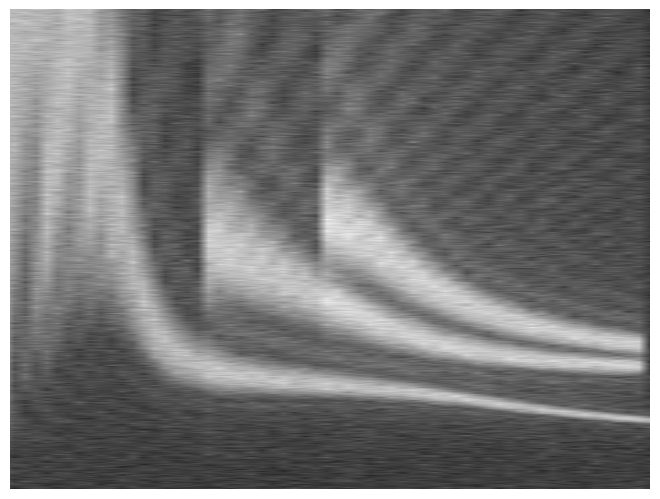

In [232]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis("off")
ax.imshow(out, aspect='auto', cmap='jet',
        extent=(f.min(), f.max(),c.min(), c.max()),origin='lower', interpolation='bilinear')

aa = 'a'
ii = 0

ax.margins(0)
ax.set_xlim(fmin, fmax)
ax.set_ylim(c.min(), c.max())
fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/diffseis/dataset/demultiple/data_train/data/{aa}{ii:03d}.png',
            dpi=300,bbox_inches='tight', pad_inches=0)
# # fig.savefig(f'/csim2/zhangzhiyu/MyProjects/DiffDispHighMode/Dispersion/Test/data/{aa}{ii:03d}.png',
# #             dpi=300,bbox_inches='tight', pad_inches=0)
# plt.close()

In [229]:
show_fj(f, c, out, fmin, fmax, 0, 'a')

In [225]:
import numpy as np
import random
import concurrent.futures
import copy

# Frequency axis
fdisp = np.linspace(1, 30, 101)
period = np.flipud(1/fdisp)         # Periods (must be sorted starting with low periods)

dc = 2.
cmin, cmax = 100., 1100.
fmin, fmax = fdisp.min(), fdisp.max()

# Velocity model                                    Model parameters
# ----------------------------------------          ------------------------------
# d        vp        vs       rho                   d        vs        nu
# [km]    [km/s]    [km/s]   [g/cm3]                [km]    [km/s]       [-]
# ----------------------------------------          ------------------------------
# 0.0109    0.3809    0.2332    0.5678              0.0109    0.2332    0.2000
# 0.0150    0.4640    0.2842    0.6757              0.0150    0.2842    0.2000
# 0.0135    0.8782    0.5000    1.1377              0.0135    0.5000    0.2601
# 0.0129    0.6532    0.4000    0.9016              0.0129    0.4000    0.2000
# 1.0000    2.4495    1.0000    2.0772                   -    1.0000    0.4000


# 原始数组
# thick = np.array([0.01, 0.02, 0.03, 0.01])
# vs = np.array([0.2, 0.4, 0.6, 0.8])
fluctuation_percentage = 0.2        # 定义浮动范围百分比


h5 = 1.0

futures = []
h1, h2, h3, h4, h5 = 0.005, 0.01, 0.01, 0.03, 1.0
v1, v2, v3, v4, v5 = 0.2, 0.3, 0.4, 0.8, 1.0
thick = np.array([h1, h2, h3, h4, h5])
vs = np.array([v1, v2, v3, v4, v5])

# thick = np.array([0.03, 0.05, 1.0])
# vs = np.array([0.3, 0.7, 1.0])

cpr = random_thick_vs(thick, vs, period, fluctuation_percentage)


f0_min, f0_max = 1/cpr[0][0].max(), 1/cpr[0][0].min()
f1_min, f1_max = 10.0, 30.0
f2_min, f2_max = 15.0, 30.0
t0_max_index = np.argmin(np.abs(1/cpr[0][0] - f0_min))
t0_min_index = np.argmin(np.abs(1/cpr[0][0] - f0_max))
t1_max_index = np.argmin(np.abs(1/cpr[1][0] - f1_min))
t1_min_index = np.argmin(np.abs(1/cpr[1][0] - f1_max))
t2_max_index = np.argmin(np.abs(1/cpr[2][0] - f2_min))
t2_min_index = np.argmin(np.abs(1/cpr[2][0] - f2_max))



cprr = copy.deepcopy(cpr)
cpr = []
cpr.append([cprr[0][0][t0_min_index:t0_max_index], cprr[0][1][t0_min_index:t0_max_index]])
cpr.append([cprr[1][0][t1_min_index:t1_max_index], cprr[1][1][t1_min_index:t1_max_index]])
cpr.append([cprr[2][0][t2_min_index:t2_max_index], cprr[2][1][t2_min_index:t2_max_index]])


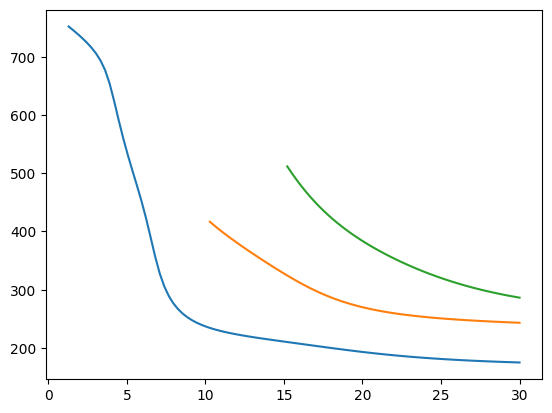

In [226]:
plt.plot(1/cpr[0][0], cpr[0][1]*1e3)
plt.plot(1/cpr[1][0], cpr[1][1]*1e3)
plt.plot(1/cpr[2][0], cpr[2][1]*1e3)
plt.show()


In [221]:
# Axes
nt = 3000 # number of time samples
dt = 1*1e-3 # time sampling in s
nx = 201 # number of spatial samples
dx = 1 # spatial sampling in m
nfft = 2**11

t, x = np.arange(nt)*dt, np.arange(nx)*dx
# Wavelet
wav = ormsby(t[:nt//2+1], f=[2, 4, 38, 40], taper=np.hanning)[0][:-1]
wav = np.roll(np.fft.ifftshift(wav), 20) # apply small shift to make it causal

# Data
dshifts, fs, vfs = [], [], []
for imode in range(3):
    dshift_, f_, vf_ = surfacewavedata(nt, dt, nx, dx, nfft, 
                                    np.flipud(1/cpr[imode][0]), np.flipud(cpr[imode][1]), wav)
    dshifts.append(1./(imode+1)**0.8 * dshift_[np.newaxis])
    fs.append(f_)
    vfs.append(vf_)


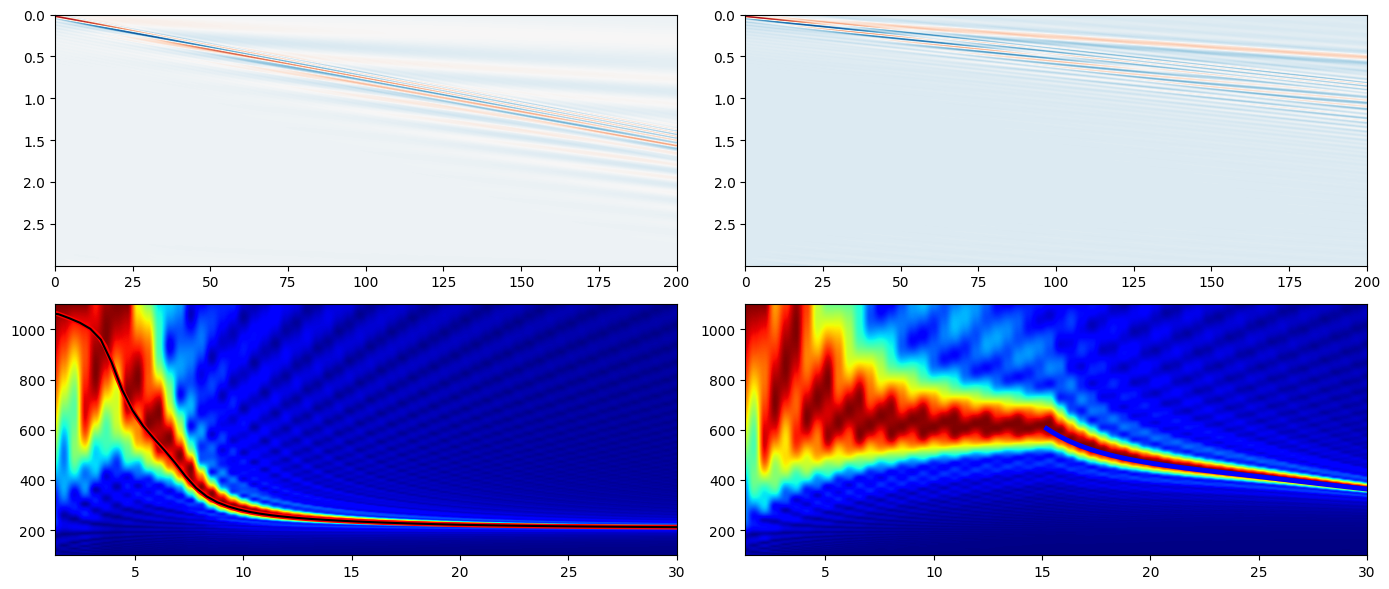

In [222]:
fmin, fmax = 2, 30

ii = 0
# f1, c1, img, U, t = park(dshifts[ii][0], dx, dt, cmin, cmax, dc, fmin, fmax)
f1, c1, img = fj(dshifts[ii][0], dx, dt, cmin, cmax)

fig, axes = plt.subplots(2, 2, figsize=(14, 6))
axes[0][0].imshow(dshifts[ii][0].T, aspect='auto', cmap='RdBu_r',
            extent=(x.min(), x.max(), t.max(),t.min()), interpolation='bilinear')
axes[1][0].imshow(img, aspect='auto', cmap='jet',
            extent=(f1[0], f1[-1],c1[0], c1[-1]),origin='lower')
axes[1][0].plot(1/cpr[ii][0], cpr[ii][1]*1e3, 'r', linewidth=3.5)
axes[1][0].plot(fs[ii], vfs[ii]*1e3, 'k')
axes[1][0].set_xlim(1/cpr[ii][0].max(), 1/cpr[ii][0].min())


ii = 2
# f1, c1, img, U, t = park(dshifts[ii][0], dx, dt, cmin, cmax, dc, fmin, fmax)
f1, c1, img = fj(dshifts[ii][0], dx, dt, cmin, cmax)
axes[0][1].imshow(dshifts[ii][0].T, aspect='auto', cmap='RdBu_r',
            extent=(x.min(), x.max(), t.max(),t.min()), interpolation='bilinear')
axes[1][1].imshow(img, aspect='auto', cmap='jet',
            extent=(f1.min(), f1.max(),c1.min(), c1.max()),origin='lower')
axes[1][1].plot(1/cpr[ii][0], cpr[ii][1]*1e3, 'b', linewidth=3.5)
# axes[1][1].plot(fs[ii], vfs[ii]*1e3, 'k')
# axes[1][1].set_xlim(1/cpr[ii][0].max(), 1/cpr[ii][0].min())
axes[1][1].set_xlim(1/cpr[0][0].max(), 1/cpr[0][0].min())
fig.tight_layout()


In [223]:
f1_min, f1_max = 10.0, 30.0
f2_min, f2_max = 15.0, 30.0

f_min_list = [f1_min, f2_min]
f_max_list = [f1_max, f2_max]

f_0, c_0, img_0 = fj(dshifts[0][0], dx, dt, cmin, cmax)

for imode in range(1, 3):
    f1, c1, img = fj(dshifts[imode][0], dx, dt, cmin, cmax)

    fmin_index = np.argmin(np.abs(f1 - f_min_list[imode-1]))
    fmax_index = np.argmin(np.abs(f1 - f_max_list[imode-1]))
    # out = np.concatenate([out, img], axis=0)
    out = np.zeros_like(img_0)
    out[:, fmin_index:fmax_index] = img[:, fmin_index:fmax_index]
    img_0 += out



(1.29, 30.0)

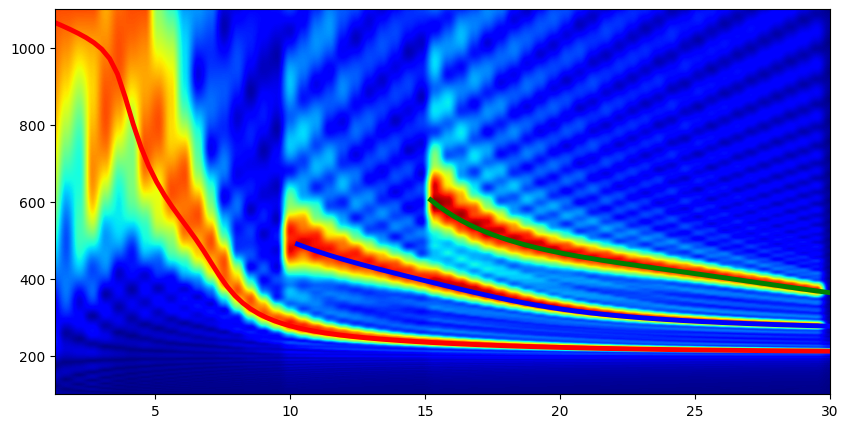

In [224]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(img_0, aspect='auto', cmap='jet',
            extent=(f_0.min(), f_0.max(),c_0.min(), c_0.max()),origin='lower')
ax.plot(1/cpr[0][0], cpr[0][1]*1e3, 'r', linewidth=3.5)
ax.plot(1/cpr[1][0], cpr[1][1]*1e3, 'b', linewidth=3.5)
ax.plot(1/cpr[2][0], cpr[2][1]*1e3, 'g', linewidth=3.5)
ax.set_xlim(1/cpr[0][0].max(), 1/cpr[0][0].min())



In [204]:
dshift = np.concatenate(dshifts).sum(0)

# 添加噪声
# dshift = dshift + np.random.randn(*dshift.shape) * 0.08 * dshift.max()
# f, c, out = fj(dshift, dx, dt, cmin, cmax)
# f1, c1, img, U, t = park(dshift, dx, dt, cmin, cmax, dc, fmin, fmax)
f1, c1, img = fj(dshift, dx, dt, cmin, cmax)


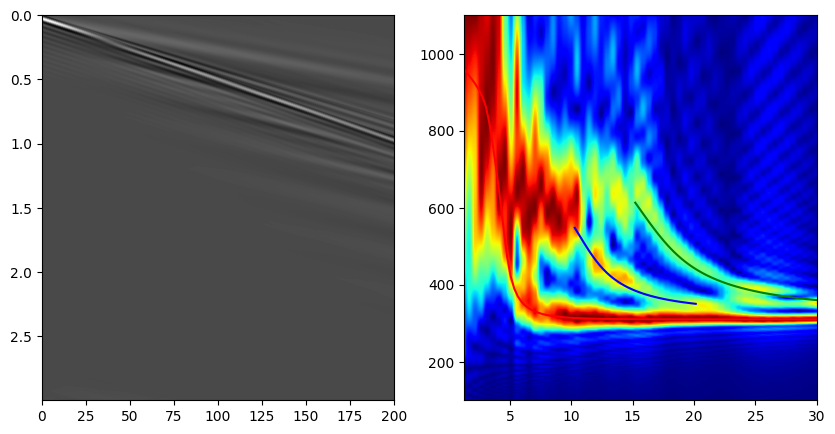

In [205]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(dshift.T, aspect='auto', cmap='gray',
            extent=(x.min(), x.max(), t.max(),t.min()))#, interpolation='bilinear')
ax[1].imshow(img, aspect='auto', cmap='jet',
            extent=(f1.min(), f1.max(),c1.min(), c1.max()),origin='lower')
# ax[1].plot(fs[0], vfs[0], 'k')
ax[1].plot(1/cpr[0][0], cpr[0][1]*1e3, 'r')
ax[1].plot(1/cpr[1][0], cpr[1][1]*1e3, 'b')
ax[1].plot(1/cpr[2][0], cpr[2][1]*1e3, 'g')
ax[1].set_xlim(1/cpr[0][0].max(), 1/cpr[0][0].min())
plt.show()